## Pre-Processing and Training Data

In [1]:
#Importing all the libraries I believe I will be using
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

from library.sb_utils import save_file

In [2]:
meta_df = pd.read_csv('SourceFiles/numerical_data.csv')

In [3]:
#as we can see, there are only numeric fields left in the Dataframe, netiher are null values left
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6726 entries, 0 to 6725
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   metastasis            6726 non-null   int64
 1   tneg                  6726 non-null   int64
 2   invasive              6726 non-null   int64
 3   breast_chest_radi     6726 non-null   int64
 4   nodal_radi            6726 non-null   int64
 5   chemo                 6726 non-null   int64
 6   antihormone           6726 non-null   int64
 7   her2_inhib            6726 non-null   int64
 8   neo                   6726 non-null   int64
 9   er                    6726 non-null   int64
 10  pr                    6726 non-null   int64
 11  p53                   6726 non-null   int64
 12  her2                  6726 non-null   int64
 13  node_status           6726 non-null   int64
 14  age                   6726 non-null   int64
 15  menopause             6726 non-null   int64
 16  node_p

In [4]:
#Counts of null values
na_df=pd.DataFrame(meta_df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount


In [5]:
#counts of response variable values
print(meta_df.shape)
meta_df.metastasis.value_counts()

(6726, 29)


0    6193
1     533
Name: metastasis, dtype: int64

From our data (6726 records), 92% are metastasis free, while 8% presented metastasis

After dropping the duplicated records, we got 88% of metastasis free and 12% of metastazed patients

### Split the data into test and train subsamples

In [6]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from pprint import pprint

y = meta_df.metastasis
X = meta_df.drop('metastasis', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

In [7]:
y0 = meta_df[meta_df['metastasis']==0].metastasis.values
X0 = meta_df[meta_df['metastasis']==0].drop('metastasis', axis=1).values

X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, test_size=.2, random_state=1)

y1 = meta_df[meta_df['metastasis']==1].metastasis.values
X1 = meta_df[meta_df['metastasis']==1].drop('metastasis', axis=1).values

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=.2, random_state=1)

X_train = np.concatenate((X0_train, X1_train))
X_test = np.concatenate((X0_test, X1_test))
y_train = np.concatenate((y0_train, y1_train))
y_test = np.concatenate((y0_test, y1_test))

#### Building the model with default parameters

In [8]:
#scale the data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)
#Random Forest Classifier
clf = RandomForestClassifier(random_state = 1)
#fit the model
model_res = clf.fit(X_train_scaled, y_train)
#Predict on test data
y_pred = model_res.predict(X_test_scaled)
#Obtain the predition probabilities
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
#Get the accuracy scores
ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

In [9]:
#Print results and default parameters
print('Random Forest: Accuracy=%.3f' % (ac))
print('Random Forest: f1-score=%.3f' % (f1))
print('Parameters currently in use:\n')
pprint(clf.get_params())
print("Classification report")
print(classification_report(y_test, y_pred))
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

Random Forest: Accuracy=0.921
Random Forest: f1-score=0.899
Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
Classification report
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1239
           1       0.50      0.14      0.22       107

    accuracy                           0.92      1346
   macro avg       0.72      0.56      0.59      1346
weighted avg       0.90      0.92      0.90      1346

Confusion Matrix
[[1224   15]
 [  92   15]]


#### Tunning the hiperparameters of the model

In [10]:
random_grid = {}

In [11]:
#I am chossing cv=10 because, without duplicates, the amount of metastazed patients are 12% and 88% are metastazed free 
#This way, I ensure there is always representation for metastazed patients.
def validate(param_name, param_range, cv=5):
    train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = X_train, y = y_train, 
                                param_name = param_name, 
                                param_range = param_range, cv = cv)
    return train_scoreNum, test_scoreNum

In [12]:
def plot_param(train_scoreNum, test_scoreNum):
    train_scoreNum = train_scoreNum * 100
    test_scoreNum = test_scoreNum * 100
    train_scores_mean = np.mean(train_scoreNum, axis=1)
    train_scores_std = np.std(train_scoreNum, axis=1)
    test_scores_mean = np.mean(test_scoreNum, axis=1)
    test_scores_std = np.std(test_scoreNum, axis=1)

    plt.title("Validation Curve with RandomForestClassifier")
    plt.xlabel(param_name)
    plt.ylabel("Accuracy Score %")
    plt.ylim(test_scoreNum.min(), train_scoreNum.max())
    lw = 1
    plt.semilogx(param_range, train_scores_mean, label="Training score", color="darkorange")
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange")
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score", color="navy")
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy")
    plt.legend(loc="best")
    plt.rcParams["figure.figsize"] = (20,5)
    plt.grid(axis='both')
    plt.show()

In [13]:
def print_scores(scores, range):
    #print("     cv=1       cv=2       cv=3       cv=4       cv=5")
    for row in zip(scores, range):
        print(row[1], row[0].mean())

##### class_weight

In [14]:
param_name = 'class_weight'
weights = np.linspace(0.04, 0.96, 24)
param_range = [{0: x, 1: 1.0-x} for x in weights]

train_scoreNum, test_scoreNum = validate(param_name, param_range)
print("train_scoreNum")
print_scores(train_scoreNum, param_range)
print("test_scoreNum")
print_scores(test_scoreNum, param_range)

train_scoreNum
{0: 0.04, 1: 0.96} 0.9737918215613384
{0: 0.07999999999999999, 1: 0.92} 0.9802973977695167
{0: 0.12, 1: 0.88} 0.9824349442379182
{0: 0.15999999999999998, 1: 0.8400000000000001} 0.9836895910780669
{0: 0.19999999999999998, 1: 0.8} 0.9845260223048328
{0: 0.23999999999999996, 1: 0.76} 0.9848977695167287
{0: 0.27999999999999997, 1: 0.72} 0.9851765799256504
{0: 0.31999999999999995, 1: 0.68} 0.9851765799256504
{0: 0.35999999999999993, 1: 0.6400000000000001} 0.9852230483271377
{0: 0.3999999999999999, 1: 0.6000000000000001} 0.9852695167286246
{0: 0.4399999999999999, 1: 0.56} 0.9852695167286246
{0: 0.4799999999999999, 1: 0.52} 0.9852695167286246
{0: 0.5199999999999999, 1: 0.4800000000000001} 0.9852695167286246
{0: 0.5599999999999999, 1: 0.44000000000000006} 0.9851765799256507
{0: 0.6, 1: 0.4} 0.9852230483271376
{0: 0.6399999999999999, 1: 0.3600000000000001} 0.9852230483271376
{0: 0.6799999999999999, 1: 0.32000000000000006} 0.9852230483271377
{0: 0.72, 1: 0.28} 0.9851765799256504
{

In [15]:
#Adding the parameter to the dictionary
#random_grid['class_weight'] = [{0: 0.04, 1: 0.96}, {0: 0.08, 1: 0.92},{0: 0.12, 1: 0.88},{0: 0.20, 1: 0.80}]
#random_grid['class_weight'] = [{0: 0.04, 1: 0.96}, {0: 0.08, 1: 0.92}]
random_grid['class_weight'] = [{0: 0.08, 1: 0.92}]

##### criterion

In [16]:
param_name = 'criterion'
param_range = ['gini','entropy']

train_scoreNum, test_scoreNum = validate(param_name, param_range)
print("train_scoreNum")
print_scores(train_scoreNum, param_range)
print("test_scoreNum")
print_scores(test_scoreNum, param_range)
#plot_param(train_scoreNum, test_scoreNum)

train_scoreNum
gini 0.9852230483271376
entropy 0.9852695167286246
test_scoreNum
gini 0.91635687732342
entropy 0.91635687732342


In [17]:
#Adding the parameter to the dictionary
random_grid['criterion'] = ['entropy']

##### max_depth

train_scoreNum
1 0.9208178438661709
2 0.9208178438661709
3 0.9208178438661709
4 0.9211431226765798
5 0.9228624535315983
6 0.9253252788104088
7 0.9289498141263941
8 0.9345724907063196
9 0.9401486988847584
10 0.9479553903345724
11 0.9561338289962826
12 0.962871747211896
13 0.9689591078066915
14 0.9751858736059479
15 0.979042750929368
16 0.9816914498141264
17 0.9835037174721188
18 0.9848977695167287
19 0.9849907063197026
20 0.9851765799256504
21 0.9852695167286246
22 0.9852695167286246
23 0.9852695167286246
24 0.9852230483271376
25 0.9851765799256504
26 0.9852695167286246
27 0.9852695167286246
test_scoreNum
1 0.9208178438661709
2 0.9208178438661709
3 0.9208178438661709
4 0.9208178438661709
5 0.9208178438661709
6 0.9215613382899628
7 0.9224907063197026
8 0.9226765799256507
9 0.9234200743494425
10 0.9230483271375466
11 0.9230483271375464
12 0.9239776951672862
13 0.9213754646840149
14 0.9204460966542751
15 0.9198884758364313
16 0.9193308550185874
17 0.916542750929368
18 0.9169144981412639
19

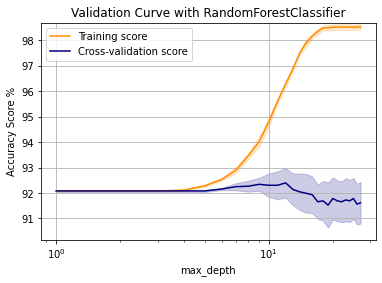

In [18]:
param_name = 'max_depth'
param_range = [int(x) for x in np.linspace(1, 27, num = 27)]

train_scoreNum, test_scoreNum = validate(param_name, param_range)
print("train_scoreNum")
print_scores(train_scoreNum, param_range)
print("test_scoreNum")
print_scores(test_scoreNum, param_range)
#param_range = param_range[:-1]
plot_param(train_scoreNum, test_scoreNum)

In [19]:
#Adding the parameter to the dictionary
random_grid['max_depth'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

##### min_samples_leaf

train_scoreNum
1 0.9852695167286246
2 0.9390334572490706
3 0.9304368029739777
4 0.9268122676579924
5 0.9239776951672862
6 0.9227695167286246
7 0.9222583643122677
test_scoreNum
1 0.9161710037174722
2 0.9232342007434944
3 0.9224907063197026
4 0.9219330855018587
5 0.9210037174721191
6 0.9208178438661709
7 0.9204460966542751


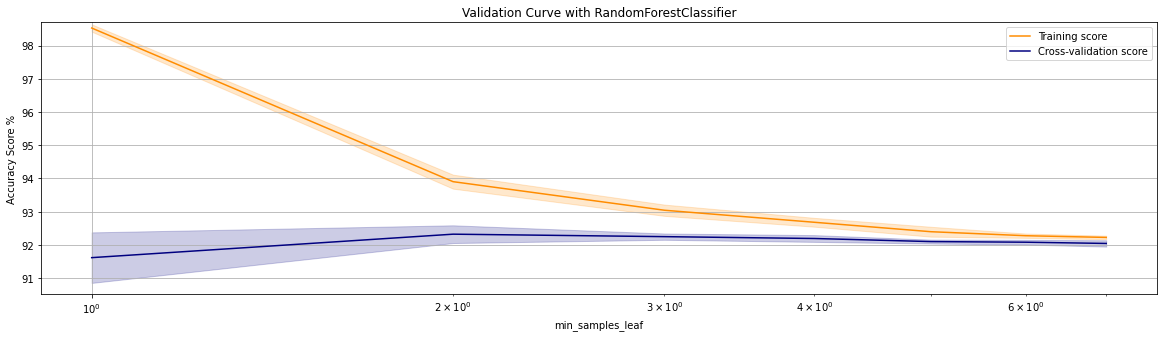

In [20]:
param_name = 'min_samples_leaf'
param_range = [1, 2, 3, 4, 5, 6, 7]

train_scoreNum, test_scoreNum = validate(param_name, param_range)
print("train_scoreNum")
print_scores(train_scoreNum, param_range)
print("test_scoreNum")
print_scores(test_scoreNum, param_range)
plot_param(train_scoreNum, test_scoreNum)

In [21]:
#Adding the parameter to the dictionary
random_grid['min_samples_leaf'] = [1, 2]

##### min_samples_split

train_scoreNum
2 0.9852695167286246
3 0.9749535315985132
4 0.9604089219330856
5 0.9522769516728624
6 0.9484200743494424
8 0.9408921933085501
10 0.9360594795539035
test_scoreNum
2 0.916542750929368
3 0.9180297397769517
4 0.9219330855018587
5 0.9228624535315986
6 0.9230483271375466
8 0.9224907063197026
10 0.9223048327137547


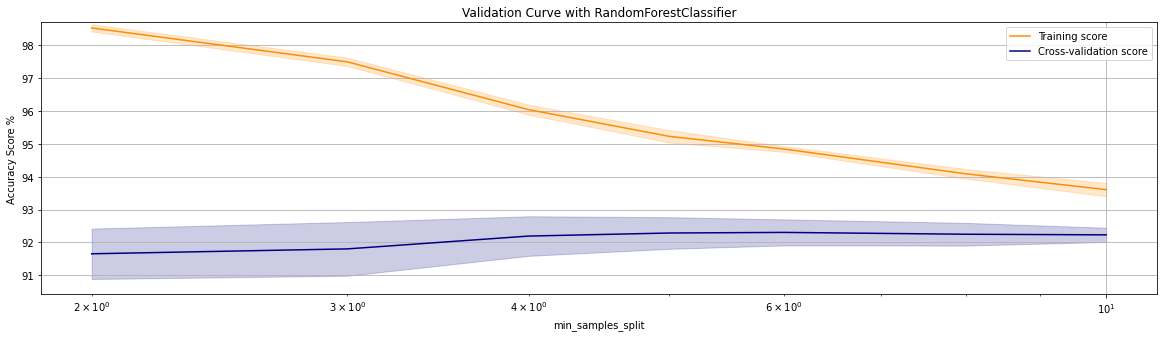

In [22]:
param_name = 'min_samples_split'
param_range = [2, 3, 4, 5, 6, 8, 10]

train_scoreNum, test_scoreNum = validate(param_name, param_range)
print("train_scoreNum")
print_scores(train_scoreNum, param_range)
print("test_scoreNum")
print_scores(test_scoreNum, param_range)
plot_param(train_scoreNum, test_scoreNum)

In [23]:
#Adding the parameter to the dictionary
random_grid['min_samples_split'] = [2, 3]

##### n_estimators

train_scoreNum
10 0.9768122676579925
50 0.9849442379182156
100 0.9852230483271376
200 0.9852695167286246
250 0.9852695167286246
300 0.9852695167286246
350 0.9852695167286246
400 0.9852695167286246
450 0.9852695167286246
500 0.9852695167286246
550 0.9852695167286246
600 0.9852695167286246
650 0.9852695167286246
700 0.9852695167286246
750 0.9852695167286246
800 0.9852695167286246
850 0.9852695167286246
900 0.9852695167286246
950 0.9852695167286246
1000 0.9852695167286246
test_scoreNum
10 0.912081784386617
50 0.9156133828996282
100 0.9159851301115243
200 0.9171003717472119
250 0.916542750929368
300 0.9169144981412639
350 0.9174721189591079
400 0.9174721189591079
450 0.9174721189591079
500 0.9171003717472118
550 0.9171003717472119
600 0.9161710037174722
650 0.9182156133828997
700 0.9174721189591079
750 0.9169144981412639
800 0.9171003717472119
850 0.9174721189591079
900 0.9163568773234202
950 0.9171003717472118
1000 0.9172862453531598


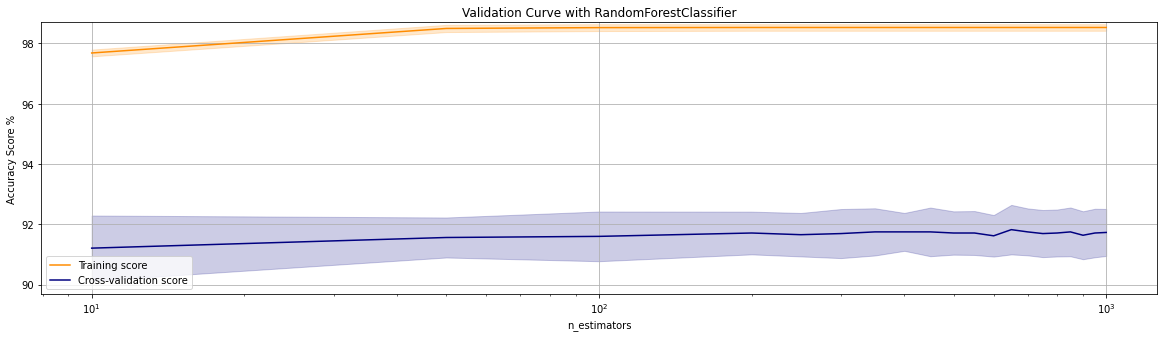

In [24]:
param_name = 'n_estimators'
param_range = [10, 50, 100, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]

train_scoreNum, test_scoreNum = validate(param_name, param_range)
print("train_scoreNum")
print_scores(train_scoreNum, param_range)
print("test_scoreNum")
print_scores(test_scoreNum, param_range)
plot_param(train_scoreNum, test_scoreNum)

In [25]:
#Adding the parameter to the dictionary
random_grid['n_estimators'] = [250]

### Setup the GridSearchCV

In [26]:
# These are the parameters to test
pprint(random_grid)

{'class_weight': [{0: 0.08, 1: 0.92}],
 'criterion': ['entropy'],
 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 'min_samples_leaf': [1, 2],
 'min_samples_split': [2, 3],
 'n_estimators': [250]}


In [27]:
from sklearn.metrics import make_scorer, accuracy_score, recall_score
scorer = make_scorer(f1_score, pos_label=1)
clf_cv = GridSearchCV(clf, random_grid, cv=5, scoring=scorer)
clf_cv.fit(X_train, y_train)
# Predict the labels of the test set: y_pred
y_pred = clf_cv.predict(X_test)

In [28]:
print("Tuned Random Forest Parameter: {}".format(clf_cv.best_params_))
print("Tuned Random Forest Accuracy: {}".format(clf_cv.best_score_))
#print("Accuracy: {}".format(clf_cv.score(X_test, y_test)))
print("Classification report")
print(classification_report(y_test, y_pred))
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

Tuned Random Forest Parameter: {'class_weight': {0: 0.08, 1: 0.92}, 'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 250}
Tuned Random Forest Accuracy: 0.34074596897206344
Classification report
              precision    recall  f1-score   support

           0       0.96      0.86      0.91      1239
           1       0.25      0.55      0.35       107

    accuracy                           0.83      1346
   macro avg       0.60      0.71      0.63      1346
weighted avg       0.90      0.83      0.86      1346

Confusion Matrix
[[1064  175]
 [  48   59]]


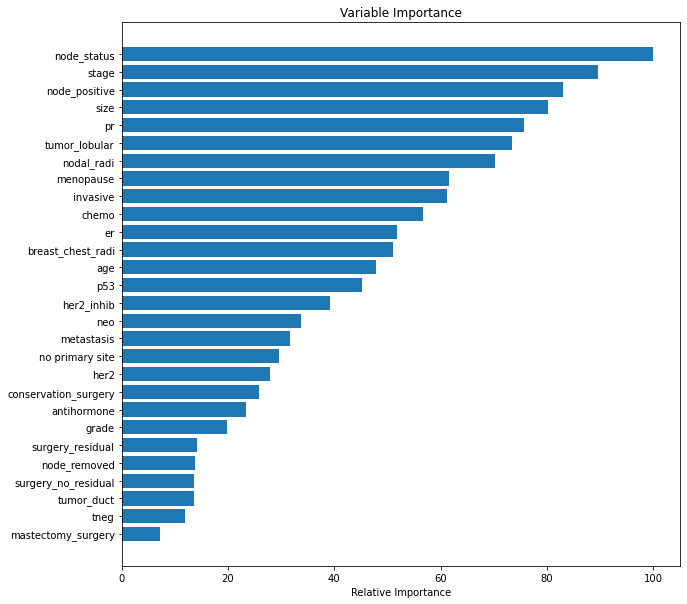

In [29]:
#Plot feature importances
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)

pos = np.arange(sorted_idx.shape[0]) + .5
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, meta_df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()